In [1]:
# install package

!pip install gdrive_dataset
!pip install --upgrade xgboost lightgbm catboost

In [2]:
# import ibrary

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from gdrivedataset import loader

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from itertools import product
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
# load dataset

file_id = '1W4GqnSclRq2RN6FriXzcq6FFo1nnP4gF'
loader.load_from_google_drive(file_id)

train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")
submission = pd.read_csv("/content/data/sample_submission.csv")

========== files ============

data/test.csv
data/sample_submission.csv
data/train.csv



## Simple EDA

In [5]:
display(train.head())
train.info()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


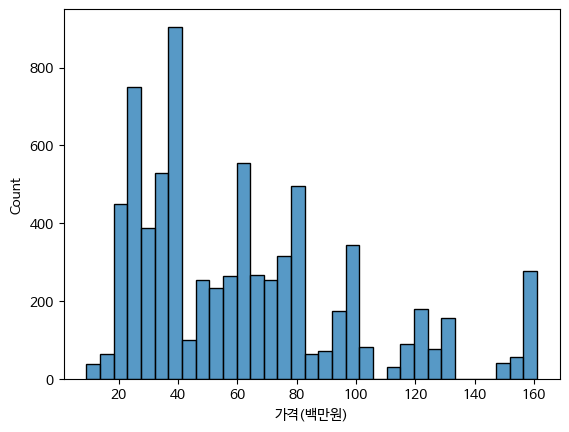

In [6]:
# distribution of prices

sns.histplot(train["가격(백만원)"])
plt.show()

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


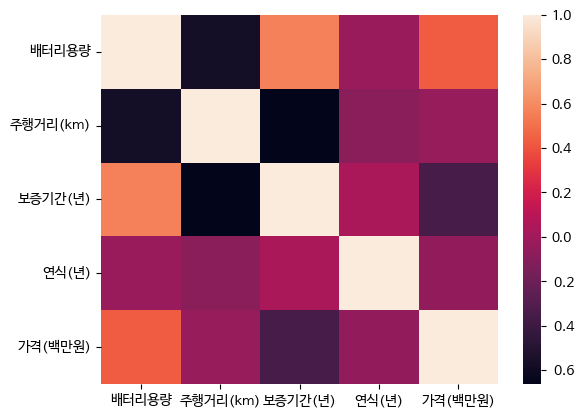

In [7]:
# correlation

corr = train[["배터리용량","주행거리(km)","보증기간(년)","연식(년)","가격(백만원)"]].corr()

display(corr)
sns.heatmap(corr);

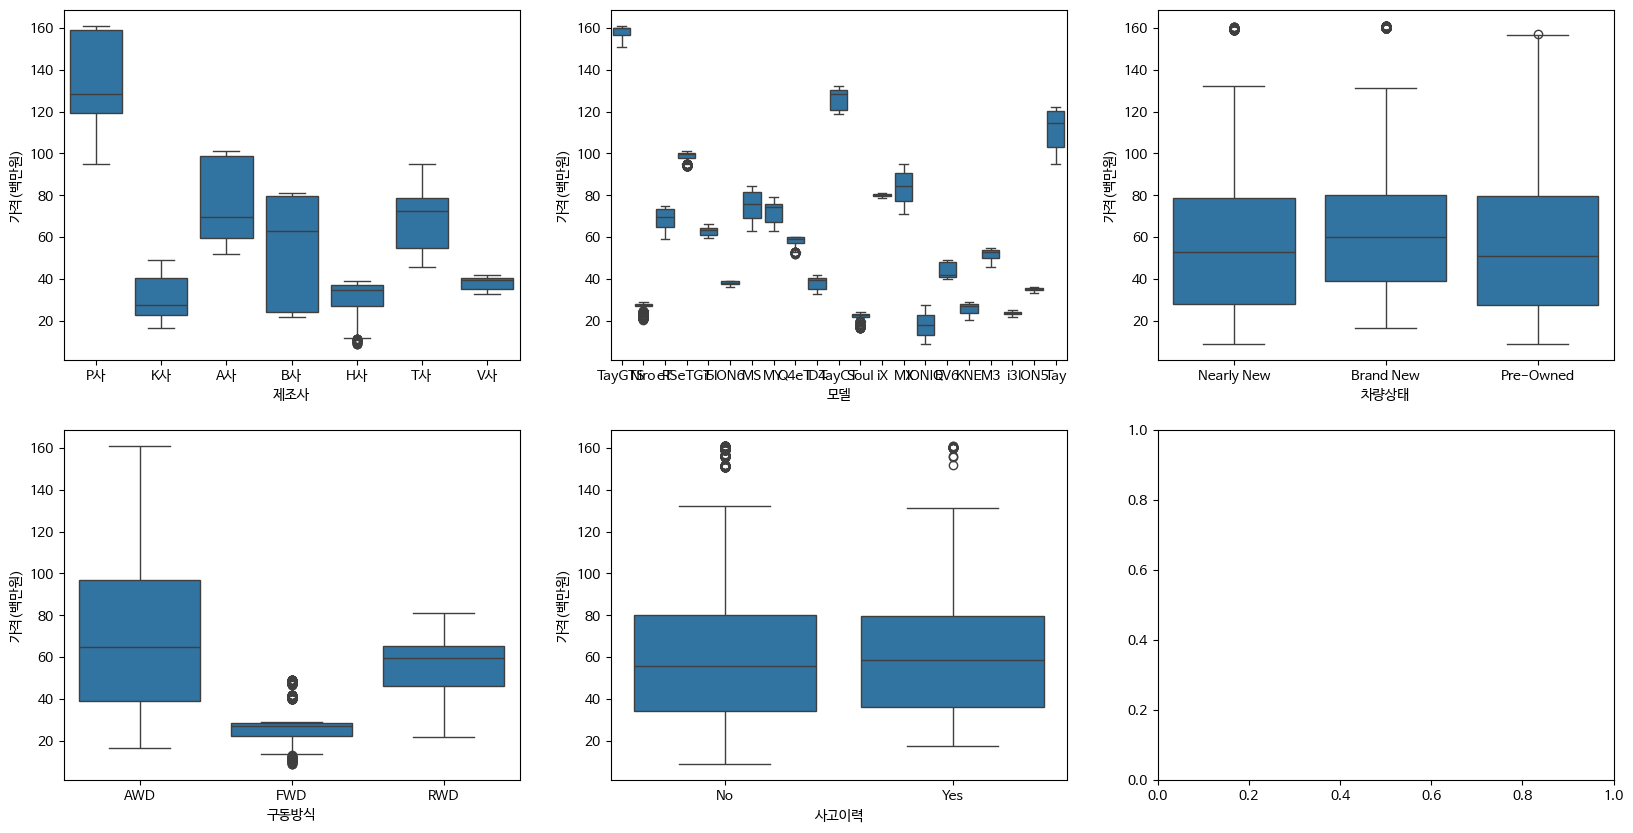

In [8]:
# box plots

columns = ["제조사","모델","차량상태","구동방식","사고이력"]

fig, axe = plt.subplots(2, 3, figsize=(20,10))

for i in range(len(columns)):
    sns.boxplot(x=columns[i], y='가격(백만원)', data=train, ax=axe[i//3, i%3]);

## Modeling

In [9]:
def product_params(params):
    combinations = []
    for values in list(product(*params.values())):
        combinations.append(
            {[*params.keys()][i]: values[i] for i in range(len(params))})
    return combinations

In [10]:
def KfoldResult(model, X, y, k, random_state=42):
    scores = {
        "mse_scores":[],
        "mae_scores":[]
    }
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_state)
    for train_index, valid_index in kfold.split(X):
        X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
        y_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        scores["mse_scores"].append(np.mean(np.square(y_pred - y_valid)))
        scores["mae_scores"].append(np.mean(np.abs(y_pred - y_valid)))

    return scores;

### RandomForest

In [11]:
# one-hot encoding

X = pd.get_dummies(train.iloc[:,1:-1],
                   columns=["제조사","모델","차량상태","구동방식","사고이력"])
y = train.iloc[:, -1]
k = 5
params = {
    "n_estimators":[100,300,500],
    "max_depth":[10,20]}
random_state = 42

# 5-Fold CV
result = []
for p in tqdm(product_params(params)):
    model = RandomForestRegressor(n_estimators=p["n_estimators"],
                                  max_depth=p["max_depth"],
                                  random_state=random_state)
    scores = KfoldResult(model=model, X=X, y=y, k=k)
    for i in range(k):
        t = {k:v for k,v in p.items()}
        t["k-fold"] = i
        t["mse_scores"] = scores["mse_scores"][i]
        t["mae_scores"] = scores["mae_scores"][i]
        result.append(t)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
result_RF = pd.DataFrame(result)
result_RF

,n_estimators,max_depth,k-fold,mse_scores,mae_scores
0,100,10,0,3.648212,1.266892
1,100,10,1,3.996343,1.322028
2,100,10,2,3.593800,1.261482
3,100,10,3,3.344034,1.220091
4,100,10,4,3.323050,1.217145
5,100,20,0,2.434715,0.737913
6,100,20,1,2.906271,0.789939
7,100,20,2,1.974975,0.697342
8,100,20,3,1.815359,0.681539
9,100,20,4,1.885297,0.712504


### XGBoost

In [13]:
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [14]:
# convert to categorical variable

X = train.iloc[:,1:-1]
for col in ["제조사","모델","차량상태","구동방식","사고이력"]:
    X[col] = X[col].astype('category')
y = train.iloc[:, -1]
k = 5
params = {
    "n_estimators":[100,300,500],
    "learning_rate":[0.25, 0.1, 0.075],
    "max_depth":[10,20]}
random_state = 42

# 5-Fold CV
result = []
for p in tqdm(product_params(params)):
    model = XGBRegressor(n_estimators=p["n_estimators"],
                         learning_rate=p["learning_rate"],
                         max_depth=p["max_depth"],
                         enable_categorical=True,
                         random_state=random_state)
    scores = KfoldResult(model=model, X=X, y=y, k=k)
    for i in range(k):
        t = {k:v for k,v in p.items()}
        t["k-fold"] = i
        t["mse_scores"] = scores["mse_scores"][i]
        t["mae_scores"] = scores["mae_scores"][i]
        result.append(t)

  0%|          | 0/18 [00:00<?, ?it/s]

In [15]:
result_XGB = pd.DataFrame(result)
result_XGB

,n_estimators,learning_rate,max_depth,k-fold,mse_scores,mae_scores
0,100,0.250,10,0,2.990981,0.790710
1,100,0.250,10,1,3.307428,0.829128
2,100,0.250,10,2,2.328201,0.724120
3,100,0.250,10,3,1.937275,0.689333
4,100,0.250,10,4,2.396236,0.748519
...,...,...,...,...,...,...
85,500,0.075,20,0,3.187780,0.835390
86,500,0.075,20,1,3.385583,0.863559
87,500,0.075,20,2,2.482535,0.756787
88,500,0.075,20,3,1.948851,0.712892


### LightGBM

In [ ]:
# convert to categorical variable

X = train.iloc[:,1:-1]
for col in ["제조사","모델","차량상태","구동방식","사고이력"]:
    X[col] = X[col].astype('category')
y = train.iloc[:, -1]
k = 5
params = {
    "n_estimators":[100,300,500],
    "learning_rate":[0.25, 0.1, 0.075],
    "max_depth":[10,20]}
random_state = 42

# 5-Fold CV
result = []
for p in tqdm(product_params(params)):
    model = LGBMRegressor(n_estimators=p["n_estimators"],
                         learning_rate=p["learning_rate"],
                         max_depth=p["max_depth"],
                         enable_categorical=True,
                         random_state=random_state)
    scores = KfoldResult(model=model, X=X, y=y, k=k)
    for i in range(k):
        t = {k:v for k,v in p.items()}
        t["k-fold"] = i
        t["mse_scores"] = scores["mse_scores"][i]
        t["mae_scores"] = scores["mae_scores"][i]
        result.append(t)

In [17]:
result_LGBM = pd.DataFrame(result)
result_LGBM

,n_estimators,learning_rate,max_depth,k-fold,mse_scores,mae_scores
0,100,0.250,10,0,2.143353,0.743517
1,100,0.250,10,1,2.217270,0.761628
2,100,0.250,10,2,1.976705,0.711669
3,100,0.250,10,3,1.765363,0.691626
4,100,0.250,10,4,1.774111,0.727693
...,...,...,...,...,...,...
85,500,0.075,20,0,2.224267,0.737296
86,500,0.075,20,1,2.316040,0.765696
87,500,0.075,20,2,2.044606,0.719481
88,500,0.075,20,3,1.803897,0.694909


### CatBoost

In [18]:
# convert to categorical variable

X = train.iloc[:,1:-1]
for col in ["제조사","모델","차량상태","구동방식","사고이력"]:
    X[col] = X[col].astype('category')
y = train.iloc[:, -1]
k = 5
params = {
    "n_estimators":[100,200,300],
    "learning_rate":[0.25, 0.1, 0.075],
    "max_depth":[5,10]}
random_state = 42

# 5-Fold CV
result = []
for p in tqdm(product_params(params)):
    model = CatBoostRegressor(n_estimators=p["n_estimators"],
                              learning_rate=p["learning_rate"],
                              max_depth=p["max_depth"],
                              cat_features=["제조사","모델","차량상태","구동방식","사고이력"],
                              random_state=random_state,
                              task_type='GPU',
                              devices='0',
                              verbose=0)
    scores = KfoldResult(model=model, X=X, y=y, k=k)
    for i in range(k):
        t = {k:v for k,v in p.items()}
        t["k-fold"] = i
        t["mse_scores"] = scores["mse_scores"][i]
        t["mae_scores"] = scores["mae_scores"][i]
        result.append(t)

  0%|          | 0/18 [00:00<?, ?it/s]

In [19]:
result_CB = pd.DataFrame(result)
result_CB

,n_estimators,learning_rate,max_depth,k-fold,mse_scores,mae_scores
0,100,0.250,5,0,5.058322,1.520003
1,100,0.250,5,1,4.509365,1.379553
2,100,0.250,5,2,3.855422,1.329452
3,100,0.250,5,3,4.657371,1.511366
4,100,0.250,5,4,3.821871,1.331330
...,...,...,...,...,...,...
85,300,0.075,10,0,2.476122,0.873600
86,300,0.075,10,1,2.289762,0.833507
87,300,0.075,10,2,2.339302,0.834149
88,300,0.075,10,3,1.948403,0.790554


### Model comparison

In [20]:
result_RF["model"] = "RF"
result_XGB["model"] = "XGB"
result_LGBM["model"] = "LGBM"
result_CB["model"] = "CB"
df = pd.concat([result_RF, result_XGB, result_LGBM, result_CB], ignore_index=True)

df.to_csv("/content/model_comparision_v1.csv", index=False)

In [21]:
df = pd.read_csv("/content/model_comparision_v1.csv", )
df.head()

,n_estimators,max_depth,k-fold,mse_scores,mae_scores,model,learning_rate
0,100,10,0,3.648212,1.266892,RF,NaN
1,100,10,1,3.996343,1.322028,RF,NaN
2,100,10,2,3.593800,1.261482,RF,NaN
3,100,10,3,3.344034,1.220091,RF,NaN
4,100,10,4,3.323050,1.217145,RF,NaN


In [28]:
df.groupby(["model", "n_estimators", "max_depth", "learning_rate"])[["mse_scores", "mae_scores"]].mean().sort_values(["mae_scores","mse_scores"]).head(10)

mse_scores  mae_scores
model n_estimators max_depth learning_rate                        
LGBM  100          20        0.100            1.837631    0.711861
                   10        0.100            1.824141    0.711911
                             0.075            1.799504    0.717454
                   20        0.075            1.794009    0.717865
      300          20        0.075            1.940474    0.718053
XGB   100          10        0.075            2.188666    0.718118
LGBM  300          10        0.075            1.945277    0.718540
                             0.100            1.991278    0.724489
XGB   100          10        0.100            2.289231    0.724699
LGBM  300          20        0.100            2.010360    0.724993

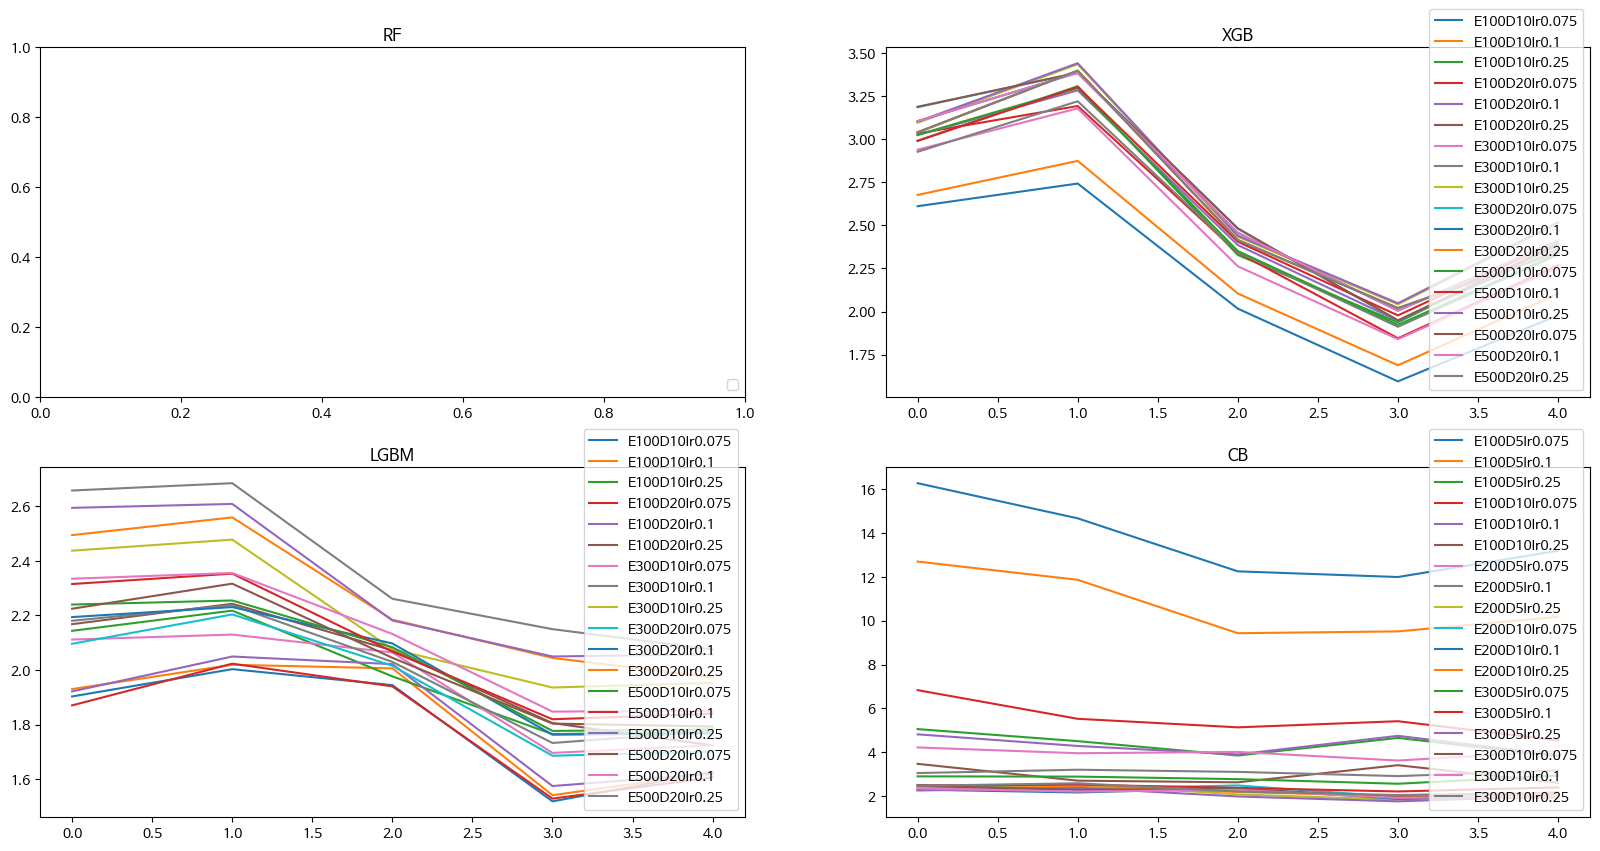

In [29]:
# plot

fig, axe = plt.subplots(2, 2, figsize=(20,10))

models = df["model"].unique()

for i, model in enumerate(models):
    for data in [*df.loc[df["model"]==model].groupby(["n_estimators", "max_depth", "learning_rate"])]:
        n_estimators, max_depth, learning_rate = data[0]
        label = f"E{n_estimators}D{max_depth}lr{learning_rate}"

        axe[i//2, i%2].plot(data[1]["k-fold"], data[1]["mse_scores"], label=label)
    axe[i//2, i%2].legend(loc='lower right')
    axe[i//2, i%2].set_title(model)

fig.show()

## Submisson

In [32]:
# convert to categorical variable

X = train.iloc[:,1:-1]
for col in ["제조사","모델","차량상태","구동방식","사고이력"]:
    X[col] = X[col].astype('category')
y = train.iloc[:, -1]
random_state = 42

# 5-Fold CV
model = LGBMRegressor(n_estimators=100,
                         learning_rate=0.01,
                         max_depth=20,
                         enable_categorical=True,
                         random_state=random_state)
model.fit(X, y)

X_test = test.iloc[:, 1:]
for col in ["제조사","모델","차량상태","구동방식","사고이력"]:
    X_test[col] = X_test[col].astype('category')

y_test = model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 7497, number of used features: 9
[LightGBM] [Info] Start training from score 62.331949
[LightGBM] [Warning] Unknown parameter: enable_categorical


In [62]:
submission = pd.read_csv("/content/data/sample_submission.csv")
submission["ID"] = submission.apply(lambda x : "TEST_00" + x["ID"].split("_")[1], axis=1)
submission["가격(백만원)"] = np.round(y_test, 2)
submission.to_csv("/content/submission.csv", index=False, encoding="UTF-8")